In [ ]:
%cd ..

import torch
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np


from src.nn.ansatz.simplified_two_design import simplified_two_design, get_num_params_simplified_two_design
from src.nn.ansatz.one_kernel import one_kernel, get_num_params_one_kernel
from src.nn.ansatz.two_kernels import two_kernels, get_num_params_two_kernels
from src.nn.ansatz.no_entanglement_circuit import no_entanglement_random_circuit
from src.nn.ansatz.full_entanglement_circuit import full_entanglement_circuit
from src.nn.measurements.default import default_measurement
from src.nn.ansatz.NQ_circuit import NQ_circuit
from src.nn.ansatz.ring_circuit import ring_circuit
from src.nn.encodings.IQP_embedding import custom_iqp_embedding
from src.nn.encodings.NQE_embedding import NQE_embedding
from src.nn.encodings.ring_embedding import ring_embedding
from src.nn.encodings.waterfall_embedding import waterfall_embedding
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding, QAOA_embedding
from src.nn.encodings.frqi_mc import FRQI_MC
from src.utils.dataset import EuroSAT, DeepSatCSV

from src.nn.models.quantum.QCNN import QuantumCircuitModel
from src.utils.training import Trainer

import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='IPython')

In [2]:
limit = 100
dataset_ = "EuroSAT"

if dataset_ == "EuroSAT":
    allowed_classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
elif dataset_ == "DeepSat4":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Other']
elif dataset_ == "DeepSat6":
    allowed_classes = ['BarrenLand', 'Trees', 'Grassland', 'Roads', 'Buildings' , 'WaterBodies']
    
config = {
    #'allowed_classes': ['Highway', 'PermanentCrop', 'River', 'SeaLake']
    #'allowed_classes': ['Trees', 'Grassland', 'Other']
    #'allowed_classes': ['BarrenLand', 'Grassland', 'Buildings']
}

allowed_classes = config.get('allowed_classes', allowed_classes)
n_classes = len(allowed_classes)

In [3]:
if dataset_ == "EuroSAT":

    output = 'np'
    data = EuroSAT(root= 'dataset/EuroSAT_RGB',
                            image_size=8,
                            examples_per_class=limit,
                            batch_size=4,
                            allowed_classes=allowed_classes,
                            output = output
                     )
    
    if output == 'dl':
        train_loader, val_loader = data.get_loaders()
    else:
        X_train, y_train, X_val, y_val, index_mapping = data.get_loaders()
    
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)
    
        train_dataset = TensorDataset(X_train, y_train) 
        val_dataset = TensorDataset(X_val, y_val)
    
        train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
        val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
else:
    if dataset_ == "DeepSat4":
        # Root
        data_path = "dataset/DeepSat4/"
        x_train_file = data_path + "X_train_sat4.csv"
        y_train_file = data_path + "y_train_sat4.csv"
        x_test_file = data_path + "X_test_sat4.csv"
        y_test_file = data_path + "y_test_sat4.csv"
        
    elif dataset_ == "DeepSat6":
        # Root
        data_path = "dataset/DeepSat6/"
        x_train_file = data_path + "X_train_sat6.csv"
        y_train_file = data_path + "y_train_sat6.csv"
        x_test_file = data_path + "X_test_sat6.csv"
        y_test_file = data_path + "y_test_sat6.csv"
        
    # Limit
    max_train_samples = limit 
    max_test_samples = int(0.2 * limit)   
    
    # Create DataLoaders
    train_dataset = DeepSatCSV(x_train_file, y_train_file, max_samples=max_train_samples)
    test_dataset = DeepSatCSV(x_test_file, y_test_file, max_samples=max_test_samples)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True


Class distribution in train set:
Class 0: 80
Class 1: 80
Class 2: 80
Class 3: 80
Class 4: 80
Class 5: 80
Class 6: 80
Class 7: 80
Class 8: 80
Class 9: 80

Class distribution in validation set:
Class 0: 20
Class 1: 20
Class 2: 20
Class 3: 20
Class 4: 20
Class 5: 20
Class 6: 20
Class 7: 20
Class 8: 20
Class 9: 20


In [4]:
#embedding = FRQI_MC
embedding = amplitude_embedding
ansatz = 'one_kernel'
measurement = default_measurement
params = {
    'embedding':{'img_pixels':8},
}


use_quantum = True
log_wandb = False #graph accuracies in wandb
plot = True #plot confusion matrix
name_run = "QCNN"

learning_rate = 0.01
epochs = 10
n_wires = 10
print(dataset_)

EuroSAT


In [5]:
if ansatz == 'one_kernel':
    circuit = one_kernel
    params['circuit'] = {'layers':1}
    weight_shapes, _ = get_num_params_one_kernel(range(n_wires), params.get('circuit',{}))
    
elif ansatz == 'two_kernels':
    circuit = two_kernels
    params['circuit'] = {'layers':1}
    weight_shapes, _ = get_num_params_two_kernels(range(n_wires), params.get('circuit',{}))
    
elif ansatz == 'simplified_two_design':
    circuit = simplified_two_design
    params['circuit'] = {'layers':15}
    weight_shapes = get_num_params_simplified_two_design(range(n_wires), params.get('circuit',{}))

params['meas_wires'] = [0,1,2] # we measure three wires chosen at random for testing purposes and bc we classify three classes

In [6]:
model_qcnn = QuantumCircuitModel(n_wires=n_wires,
                     embedding=embedding,
                     circuit=circuit,
                     measurement=measurement,
                     params=params,
                     weight_shapes={'weights':weight_shapes})

In [7]:
name_prueba = f"Pruebas QCNN"
trainer_qcnn = Trainer(model = model_qcnn,
                  train_loader = train_loader,
                  val_loader = val_loader,
                  epochs = epochs,
                  log_wandb = log_wandb,
                  wandb_project = name_prueba,
                  wandb_run_name = name_run,
                  use_quantum = use_quantum,
                  plot = plot,
                  allowed_classes = allowed_classes,
                  lr = learning_rate,
                  use_schedulefree = True)
trainer_qcnn.device = 'cpu'

Epoch [1/10]: Train Loss = 2.2962, Train Acc = 13.00%, Val Loss = 2.2818, Val Acc = 17.00%
Epoch [2/10]: Train Loss = 2.2720, Train Acc = 15.50%, Val Loss = 2.2620, Val Acc = 16.50%
Epoch [3/10]: Train Loss = 2.2574, Train Acc = 16.12%, Val Loss = 2.2479, Val Acc = 18.00%
Epoch [4/10]: Train Loss = 2.2468, Train Acc = 16.50%, Val Loss = 2.2364, Val Acc = 19.50%
Epoch [5/10]: Train Loss = 2.2375, Train Acc = 18.00%, Val Loss = 2.2273, Val Acc = 20.00%
Epoch [6/10]: Train Loss = 2.2310, Train Acc = 19.50%, Val Loss = 2.2217, Val Acc = 21.00%
Epoch [7/10]: Train Loss = 2.2259, Train Acc = 20.62%, Val Loss = 2.2166, Val Acc = 21.50%
Epoch [8/10]: Train Loss = 2.2221, Train Acc = 21.25%, Val Loss = 2.2133, Val Acc = 23.50%
Epoch [9/10]: Train Loss = 2.2195, Train Acc = 21.38%, Val Loss = 2.2100, Val Acc = 22.00%
Epoch [10/10]: Train Loss = 2.2166, Train Acc = 21.62%, Val Loss = 2.2078, Val Acc = 22.00%


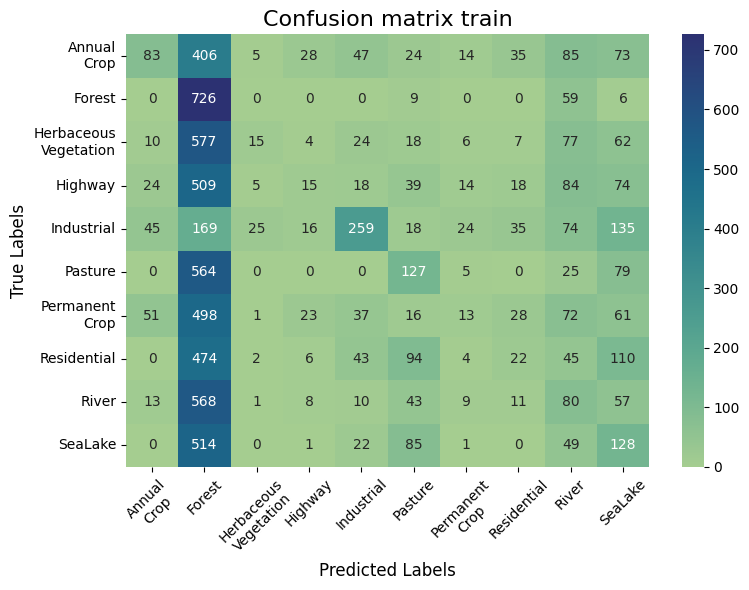

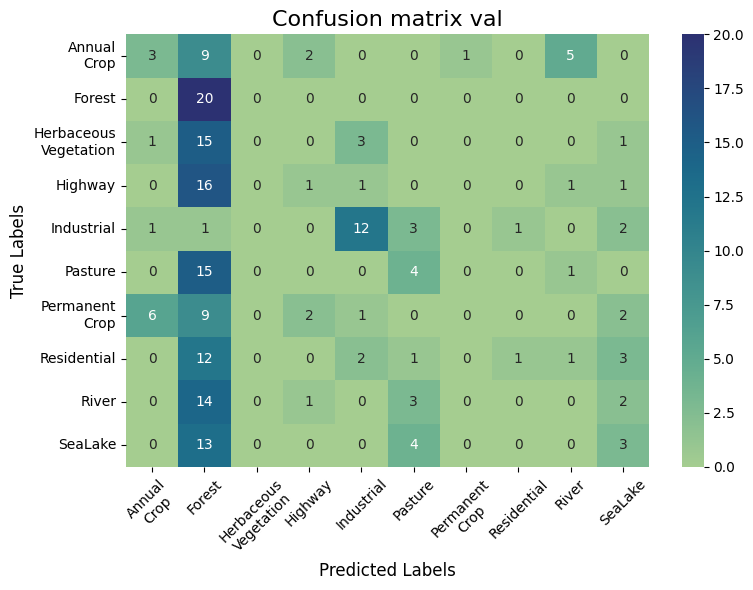

Tiempo de entrenamiento: 7 minutos y 43 segundos


In [8]:
t0 = time.time()
trainer_qcnn.fit()
t1 = (time.time()-t0)/60
print(f"Tiempo de entrenamiento: {int(t1)} minutos y {int(np.round((t1-int(t1))*60,0))} segundos")